<a href="https://colab.research.google.com/github/EuZx/Overview/blob/master/optimized_rl_marketing_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-*- coding: utf-8 -*-

In [1]:
"""Optimized_RL_Marketing.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1rueikW0Prv38W8DOLZmKywlzdWYKtsdm

Updated by: ChatGPT

This script implements a reinforcement learning model (Deep Q-Network) for optimizing marketing spend.
It includes hyperparameter tuning using Optuna, a validation phase, and detailed documentation.

Usage:
- Ensure the necessary libraries are installed.
- Upload your data file containing columns for 'Number of Visitors', 'Total Gross Sales', and 'Marketing Spend'.
- Run the script to train the model and evaluate its performance on both training and validation sets.

"""



"Optimized_RL_Marketing.ipynb\n\nAutomatically generated by Colab.\n\nOriginal file is located at\n    https://colab.research.google.com/drive/1rueikW0Prv38W8DOLZmKywlzdWYKtsdm\n\nUpdated by: ChatGPT\n\nThis script implements a reinforcement learning model (Deep Q-Network) for optimizing marketing spend.\nIt includes hyperparameter tuning using Optuna, a validation phase, and detailed documentation.\n\nUsage:\n- Ensure the necessary libraries are installed.\n- Upload your data file containing columns for 'Number of Visitors', 'Total Gross Sales', and 'Marketing Spend'.\n- Run the script to train the model and evaluate its performance on both training and validation sets.\n\n"

Install necessary library for hyperparameter optimization

In [2]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.1 MB/s eta 0:00:00


In [8]:
!pip install gym

Import necessary libraries

In [17]:
import torch
torch.cuda.empty_cache()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
import gym
from gym import spaces
from sklearn.model_selection import train_test_split
from google.colab import files


Upload the file from your local machine

In [4]:
uploaded = files.upload()


Saving Sales_Data_Apr2017_Mar2024.xlsx to Sales_Data_Apr2017_Mar2024.xlsx


Load the uploaded Excel file into a DataFrame

In [5]:
file_name = list(uploaded.keys())[0]
data = pd.read_excel(file_name)


Split the data into training and validation sets (80% training, 20% validation)

In [6]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)


Custom Gym environment for marketing spend optimization

In [11]:
class MarketingEnv(gym.Env):
    def __init__(self, data):
        super(MarketingEnv, self).__init__()
        self.data = data
        self.current_step = 0


Define action and observation space

In [19]:
class MarketingEnv(gym.Env):
    def __init__(self, data):
        super(MarketingEnv, self).__init__()
        self.data = data
        self.current_step = 0

        # Define action and observation space
        self.action_space = spaces.Discrete(5)
        self.observation_space = spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        return self._next_observation()

    def _next_observation(self):
        obs = self.data.iloc[self.current_step]
        state = np.array([
            obs['Number of Visitors'] / 5000,
            obs['Total Gross Sales'] / 10000,
            obs['Marketing Spend'] / 8000
        ])
        return state

    def step(self, action):
        marketing_spend = action * 1000  # Convert action to actual spend
        sales = self.data.iloc[self.current_step]['Total Gross Sales']
        reward = sales - marketing_spend  # Reward is profit (sales - spend)
        self.current_step += 1

        done = self.current_step >= len(self.data) - 1  # Check if the episode is done
        next_state = self._next_observation() if not done else np.zeros_like(state)

        return next_state, reward, done, {}

Define the DQN Agent with Hyperparameter Tuning using Optuna

In [21]:
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.95, epsilon_decay=0.995, network_size=32):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=500)  # Reduced buffer size to save memory
        self.gamma = gamma  # Discount rate
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate

        # Build the Q-network
        self.model = self._build_model(network_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

    def _build_model(self, network_size):
        # Define a simpler network architecture to reduce computational load
        model = nn.Sequential(
            nn.Linear(self.state_size, network_size),
            nn.ReLU(),
            nn.Linear(network_size, network_size),
            nn.ReLU(),
            nn.Linear(network_size, self.action_size)
        )
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state).unsqueeze(0)  # Convert to torch tensor and add batch dimension
            next_state = torch.FloatTensor(next_state).unsqueeze(0)  # Convert to torch tensor and add batch dimension

            # Get the current Q-values predicted by the model for the current state
            target_f = self.model(state)  # This should output a tensor of shape [1, action_size]

            # Ensure target_f has the correct shape for action indexing
            target_f = target_f.squeeze(0)  # Remove the batch dimension, now shape should be [action_size]

            # Debug: Print shapes to ensure correct indexing
            print(f"target_f shape: {target_f.shape}, Action: {action}")

            # Check if action is within the valid range
            if action >= target_f.size(0):
                print(f"Invalid action: {action} for target_f with shape: {target_f.size(0)}")
                continue  # Skip this loop iteration if the action is invalid

            # Compute the target Q-value for the action taken
            target = reward
            if not done:
                # Compute the target as the reward plus the discounted max future Q-value
                target = reward + self.gamma * torch.max(self.model(next_state)).item()

            # Update the Q-value for the action taken in target_f
            target_f[action] = target

            # Perform gradient descent to update the model weights
            self.optimizer.zero_grad()
            loss = self.criterion(self.model(state).squeeze(0), target_f)
            loss.backward()
            self.optimizer.step()

        # Reduce epsilon (exploration rate) to gradually reduce random actions
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

Suggest hyperparameters to tune

In [22]:
def objective(trial):
    # Suggest hyperparameters to tune
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    gamma = trial.suggest_uniform('gamma', 0.8, 0.99)
    epsilon_decay = trial.suggest_uniform('epsilon_decay', 0.95, 0.999)
    network_size = trial.suggest_int('network_size', 16, 64)

    # Initialize environment and agent
    env = MarketingEnv(train_data)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size, learning_rate, gamma, epsilon_decay, network_size)

    batch_size = 32
    n_episodes = 30
    total_reward = 0

    for e in range(n_episodes):
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        episode_reward = 0
        for time in range(200):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward
            if done:
                break
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
        total_reward += episode_reward

    return total_reward / n_episodes  # Return average reward as the optimization metric

# Use Optuna to find the best hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
best_params = study.best_params
print("Best hyperparameters found:", best_params)

[I 2024-08-17 14:45:25,413] A new study created in memory with name: no-name-ae92579b-6fef-4cf5-96a0-89e6c5b8d900
<ipython-input-22-5cce5022fd60>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
<ipython-input-22-5cce5022fd60>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.99)
<ipython-input-22-5cce5022fd60>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  epsilon_decay = trial.suggest_uniform('epsilon_decay', 0.95, 0.999)


Streaming output truncated to the last 5000 lines.
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Act

[I 2024-08-17 14:48:38,632] Trial 0 finished with value: -390764.7933333335 and parameters: {'learning_rate': 0.00029762246416990855, 'gamma': 0.9107375855546013, 'epsilon_decay': 0.9623749182899481, 'network_size': 35}. Best is trial 0 with value: -390764.7933333335.


Streaming output truncated to the last 5000 lines.
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Act

[I 2024-08-17 14:51:53,049] Trial 1 finished with value: -132698.12666666662 and parameters: {'learning_rate': 0.0063656910223728585, 'gamma': 0.929690274033944, 'epsilon_decay': 0.976256575132183, 'network_size': 18}. Best is trial 1 with value: -132698.12666666662.


Streaming output truncated to the last 5000 lines.
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with sha

[I 2024-08-17 14:55:03,621] Trial 2 finished with value: -390998.1266666668 and parameters: {'learning_rate': 0.0003425765161284289, 'gamma': 0.8665018683310568, 'epsilon_decay': 0.9549166612052852, 'network_size': 34}. Best is trial 1 with value: -132698.12666666662.


Streaming output truncated to the last 5000 lines.
target_f shape: torch.Size([1, 5]), Action: 2
Invalid action: 2 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 2
Invalid action: 2 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 2
Invalid action: 2 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 2
Invalid action: 2 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 2
Invalid action: 2 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 2
Invalid action: 2 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 2
Invalid action: 2 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 2
Invalid action: 2 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 2
Invalid action: 2 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 2
Invalid action: 2 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Act

[I 2024-08-17 14:58:16,034] Trial 3 finished with value: 1335.206666666671 and parameters: {'learning_rate': 0.00016275975361646514, 'gamma': 0.9323284919508907, 'epsilon_decay': 0.9914788128560721, 'network_size': 47}. Best is trial 3 with value: 1335.206666666671.


Streaming output truncated to the last 5000 lines.
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Act

[I 2024-08-17 15:01:22,915] Trial 4 finished with value: 195401.87333333344 and parameters: {'learning_rate': 0.00016882761738667371, 'gamma': 0.801453754352169, 'epsilon_decay': 0.9914622089462142, 'network_size': 23}. Best is trial 4 with value: 195401.87333333344.


Streaming output truncated to the last 5000 lines.
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Act

[I 2024-08-17 15:04:36,284] Trial 5 finished with value: 170201.87333333347 and parameters: {'learning_rate': 0.0064627587995841895, 'gamma': 0.9883178962261308, 'epsilon_decay': 0.9915195294785047, 'network_size': 58}. Best is trial 4 with value: 195401.87333333344.


Streaming output truncated to the last 5000 lines.
target_f shape: torch.Size([1, 5]), Action: 2
Invalid action: 2 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 2
Invalid action: 2 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 2
Invalid action: 2 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 2
Invalid action: 2 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 2
Invalid action: 2 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 2
Invalid action: 2 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 2
Invalid action: 2 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 2
Invalid action: 2 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 2
Invalid action: 2 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 2
Invalid action: 2 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Act

[I 2024-08-17 15:07:44,994] Trial 6 finished with value: 701.8733333333371 and parameters: {'learning_rate': 0.00019285426968560944, 'gamma': 0.8454271648487918, 'epsilon_decay': 0.9875743125049756, 'network_size': 55}. Best is trial 4 with value: 195401.87333333344.


Streaming output truncated to the last 5000 lines.
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Act

[I 2024-08-17 15:10:52,661] Trial 7 finished with value: -208698.12666666662 and parameters: {'learning_rate': 0.0016818045665639, 'gamma': 0.9443243193316582, 'epsilon_decay': 0.9884853563771638, 'network_size': 45}. Best is trial 4 with value: 195401.87333333344.


Streaming output truncated to the last 5000 lines.
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 3
Invalid action: 3 for target_f with sha

[I 2024-08-17 15:14:03,677] Trial 8 finished with value: -268264.7933333333 and parameters: {'learning_rate': 0.0023695381189292103, 'gamma': 0.9072373739444628, 'epsilon_decay': 0.9900230721734717, 'network_size': 42}. Best is trial 4 with value: 195401.87333333344.


Streaming output truncated to the last 5000 lines.
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Act

[I 2024-08-17 15:17:02,329] Trial 9 finished with value: -389331.46000000014 and parameters: {'learning_rate': 0.00016716790446382477, 'gamma': 0.8864567034614417, 'epsilon_decay': 0.9543895158641509, 'network_size': 19}. Best is trial 4 with value: 195401.87333333344.


target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 4
Invalid action: 4 for target_f with shape: 1

Train the final model using the best hyperparameters

In [26]:
# Initialize the environment
env = MarketingEnv(train_data)

# Define the state and action sizes based on the environment
state_size = env.observation_space.shape[0]  # Number of features in the observation

action_size = env.action_space.n  # Number of possible actions

# Define the batch size for experience replay
batch_size = 32  # You can adjust this number based on your memory and computational power

agent = DQNAgent(state_size, action_size, **best_params)
n_episodes = 50
validation_rewards = []

for e in range(n_episodes):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    for time in range(200):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(f"Episode: {e}/{n_episodes}, Score: {time}, Epsilon: {agent.epsilon:.2}")
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

    # Validation phase
    env = MarketingEnv(val_data)
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    val_reward = 0
    for time in range(200):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        val_reward += reward
        if done:
            break
    validation_rewards.append(val_reward)

print(f"Average validation reward: {np.mean(validation_rewards)}")

Streaming output truncated to the last 5000 lines.
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with shape: 1
target_f shape: torch.Size([1, 5]), Action: 1
Invalid action: 1 for target_f with sha

Save the model after training

In [27]:
torch.save(agent.model.state_dict(), 'dqn_model_optimized.pth')
print("Model saved.")

Model saved.


Visualization: Plot the rewards over episodes

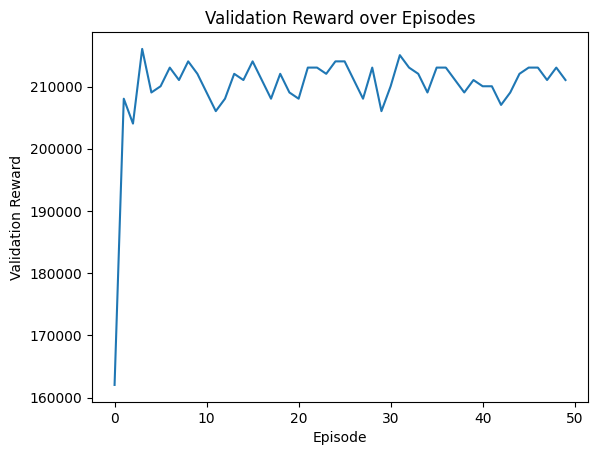

In [28]:
plt.plot(range(len(validation_rewards)), validation_rewards)
plt.xlabel('Episode')
plt.ylabel('Validation Reward')
plt.title('Validation Reward over Episodes')
plt.show()

**Using saved model**

In [33]:
import torch

uploadednew = files.upload()
file_name2 = list(uploadednew.keys())[0]
new_data = pd.read_excel(file_name2)

# Initialize the environment and the agent
env = MarketingEnv(new_data)  # Replace new_data with the new dataset
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
# Example with the same network size that was used during training
network_size = 23  # This should match the size used during training

# Recreate the agent with the exact same parameters
agent = DQNAgent(state_size, action_size, network_size=network_size)
agent.model.load_state_dict(torch.load('dqn_model_optimized.pth'))
agent.model.eval()  # Set the model to evaluation mode

Saving synthetic_marketing_data.xlsx to synthetic_marketing_data (1).xlsx


Sequential(
  (0): Linear(in_features=3, out_features=23, bias=True)
  (1): ReLU()
  (2): Linear(in_features=23, out_features=23, bias=True)
  (3): ReLU()
  (4): Linear(in_features=23, out_features=5, bias=True)
)

In [34]:
state = env.reset()
state = np.reshape(state, [1, state_size])

done = False
total_reward = 0

while not done:
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    next_state = np.reshape(next_state, [1, state_size])
    state = next_state
    total_reward += reward

print(f"Total Reward for this episode: {total_reward}")

Total Reward for this episode: 2703278


In [35]:
# Assuming actions represent different levels of marketing spend (e.g., $1000 increments)
spend_levels = [i * 1000 for i in range(10)]  # Adjust based on your action space definition

# Initialize environment and agent as before
state = env.reset()
state = np.reshape(state, [1, state_size])

done = False
total_reward = 0
decision_history = []

while not done:
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    next_state = np.reshape(next_state, [1, state_size])
    state = next_state
    total_reward += reward

    # Map action to marketing spend and store it
    marketing_spend = spend_levels[action]
    decision_history.append({
        'Action': action,
        'Marketing Spend': marketing_spend,
        'Reward': reward
    })

# Convert the decision history to a DataFrame for easier interpretation
decision_df = pd.DataFrame(decision_history)

print(decision_df)

    Action  Marketing Spend  Reward
0        3             3000   13873
1        1             1000   14675
2        1             1000    9161
3        2             2000   45065
4        4             4000   32557
..     ...              ...     ...
94       2             2000   39968
95       4             4000   38562
96       3             3000   20545
97       2             2000    8663
98       4             4000   40766

[99 rows x 3 columns]


In [36]:
for index, row in decision_df.iterrows():
    print(f"Step {index + 1}:")
    print(f"  Recommended Marketing Spend: ${row['Marketing Spend']}")
    print(f"  Expected Reward: ${row['Reward']}")
    print("-" * 40)


Step 1:
  Recommended Marketing Spend: $3000
  Expected Reward: $13873
----------------------------------------
Step 2:
  Recommended Marketing Spend: $1000
  Expected Reward: $14675
----------------------------------------
Step 3:
  Recommended Marketing Spend: $1000
  Expected Reward: $9161
----------------------------------------
Step 4:
  Recommended Marketing Spend: $2000
  Expected Reward: $45065
----------------------------------------
Step 5:
  Recommended Marketing Spend: $4000
  Expected Reward: $32557
----------------------------------------
Step 6:
  Recommended Marketing Spend: $2000
  Expected Reward: $41763
----------------------------------------
Step 7:
  Recommended Marketing Spend: $0
  Expected Reward: $42606
----------------------------------------
Step 8:
  Recommended Marketing Spend: $2000
  Expected Reward: $19534
----------------------------------------
Step 9:
  Recommended Marketing Spend: $3000
  Expected Reward: $36127
-------------------------------------

In [37]:
total_spend = decision_df['Marketing Spend'].sum()
average_reward = decision_df['Reward'].mean()

print(f"Final Recommendation:")
print(f"  Total Marketing Spend: ${total_spend}")
print(f"  Average Reward per Action: ${average_reward}")
print(f"  Total Reward: ${total_reward}")


Final Recommendation:
  Total Marketing Spend: $191000
  Average Reward per Action: $27235.131313131315
  Total Reward: $2696278
